In [1]:
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio import mask as raster_mask
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely import speedups

speedups.disable()



In [2]:
import utils

In [3]:
from skimage.transform import resize

In [4]:
grid_sizes = utils.get_grid_sizes()


# Structure

"train" folder will contain one numpy mask for each classtype for every train image (train_y) and an adjusted numpy array for every 16 band raster file (train_X).


In [5]:
train_X_path = os.path.join('train','train_X')
train_y_path = os.path.join('train','train_y')
train_path = 'train'

train_dirs = [train_path,train_X_path,train_y_path]

for directory in train_dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

                      

# 1: Prepare and scale train polygons

In [6]:
### this will be the standard image size for training & testing
base_size = 512

In [7]:
wkt_train = pd.read_csv('train_wkt_v4.csv')
wkt_train['MultipolygonWKT'] = wkt_train['MultipolygonWKT'].apply(shapely.wkt.loads)

train_gpd = gpd.GeoDataFrame(wkt_train,geometry='MultipolygonWKT')
train_gpd.rename({'MultipolygonWKT':'geometry'},axis=1,inplace=True)

In [8]:
def get_src_h_w(src):
    w = src.height
    h = src.width

    return w, h

In [9]:
def get_H_W_scalers(w,H):
    W = w**2 / (w+1)
    H = h**2 / (h+1)
    return W,H

In [10]:
# def get_mask(w,h,exterior,interior,classtype):
#     img_mask = np.zeros((w,h), np.uint8)
#     cv2.fillPoly((w,h), exterior, classtype)
#     if len(interior) > 0:
#         cv2.fillPoly((w,h), interior, 0)
#     return img_mask


In [11]:
train_gpd['dummy_geo'] = 0
train_gpd['dummy_geo'] = train_gpd['dummy_geo'].astype('object')
train_ids = train_gpd['ImageId'].unique()

raster_dict = {}
img_shape = (base_size,base_size)

In [12]:
for image_id in train_ids:
    img = rasterio.open(os.path.join('three_band',image_id+'.tif'))
    w, h = get_src_h_w(img)
#     w, h = img_shape
    W, H = get_H_W_scalers(h,w)
    # store w, h in a dictionary for sixteen band rasters
    
    raster_dict[image_id] = (w,h)
    
    xmax, ymax = utils.get_image_max(image_id, grid_sizes)
    
    target_array = np.empty((base_size,base_size,10),dtype=np.int8)
    
    for index, row in train_gpd.loc[train_gpd['ImageId']==image_id].iterrows():
        classtype = row['ClassType']
        geo = row['geometry']
        if str(geo) == "GEOMETRY COLLECTION EMPTY" or str(geo) == 'MULTIPOLYGON EMPTY':
            train_gpd.at[index,'dummy_geo'] = np.nan
            mask = np.zeros((img_shape),np.uint8)

        else:
            ### scale polygons
            polys = []
            for poly in geo:

                x_ext,y_ext = np.array(poly.exterior.coords.xy[0]), np.array(poly.exterior.coords.xy[1])
                exterior = utils.convert_xy_to_raster(x_ext,y_ext,xmax,ymax,W,H)
                interiors = []
                for interior in poly.interiors:
                    x_int, y_int = np.array(interior.coords.xy[0]),np.array(interior.coords.xy[1])
                    interiors.append(utils.convert_xy_to_raster(x_int, y_int,xmax,ymax,W,H))

                scaled_poly = shapely.geometry.Polygon(exterior,interiors)

                polys.append(scaled_poly)

            polygon_val = shapely.geometry.MultiPolygon(polys)
            train_gpd.at[index,'dummy_geo'] = polygon_val
            ### get polygon mask
#             print(image_id,classtype)
#             mask = get_mask(w,h,exterior,interiors,classtype)
            mask = raster_mask.mask(img,polygon_val,all_touched=True)
#             print(mask.shape)
            resized_mask = tf.image.resize_with_pad(np.moveaxis(mask[0],0,2),img_shape[0],img_shape[1])
            mask = np.max(resized_mask,axis=2)
            mask = np.where(mask==np.min(resized_mask),0,classtype)
        target_array[:,:,classtype-1] = mask
        ### save mask
#         classtype = row['ClassType']
#         np.save(os.path.join(train_y_path,image_id+"_"+str(classtype)),mask)
        np.save(os.path.join(train_y_path,image_id),target_array)
    img.close()
    


C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [13]:
test_1 = np.load(os.path.join('train','train_y','6040_2_2.npy'))

In [14]:
train_gpd.set_geometry('dummy_geo',inplace=True)
train_gpd.drop('geometry',axis=1,inplace=True)
train_gpd.to_file('train_gdf_'+str(img_shape[0])+'.geojson',driver='GeoJSON')

# 2: Create X_train, X_label

X_train will be the combined 16 - band images.
X_label will be a mask of the polygons

In [15]:
# raster dict created in previous step to get the h and w of the thirteen band images. Keys = image id, values = (w,h) tuple

band_suffix = ["P","M","A"]

Based on the tags in the sixteen band rasters, we know that P is panchromatic (band 1), M is multispectral (bands 2 - 9), and A is SWIR (bands 10-17). We'll read each image into a numpy array and rename the bands accordingly.

In [16]:
def scale_pixels(img):
    
    img_scaled = np.empty(img.shape)
    for i,band in enumerate(img):
        img_max = np.max(band)
        img_min = np.min(band)

        scaled_band = (band - img_min) * 1/(img_max-img_min)

        img_scaled[i] = scaled_band
        
    return img_scaled

In [17]:
for image_id in train_ids:
#     w,h = raster_dict[image_id]
    array_list = []
    for band in band_suffix:
        img = rasterio.open(os.path.join('sixteen_band',image_id+"_"+band+".tif"))
        scaled_img = img.read(out_shape=(img_shape[0],img_shape[1]))
        scaled_img = scale_pixels(scaled_img)
        array_list.append(scaled_img)
        img.close()
    train_X = np.concatenate(array_list)
    np.save(os.path.join(train_X_path,image_id),train_X)
        

In [18]:
# remove train dataframe to save memory
train_gpd=None
wkt_train=None

In [19]:
# Split into training and test sets

train_imgs = train_ids[:20]
test_imgs = train_ids[20:]

In [20]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Model Test: Class 1


In [21]:
# from keras.models import Model, load_model
# from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as K

In [22]:
# smooth = 1e-12

In [23]:
# def jaccard_coef(y_true, y_pred):
#     # __author__ = Vladimir Iglovikov
#     intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
#     sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

#     jac = (intersection + smooth) / (sum_ - intersection + smooth)

#     return K.mean(jac)


# def jaccard_coef_int(y_true, y_pred):
#     # __author__ = Vladimir Iglovikov
#     y_pred_pos = K.round(K.clip(y_pred, 0, 1))

#     intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
#     sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return K.mean(jac)

# def get_unet():
#     inputs = Input((17, base_size, base_size))
#     conv1 = Convolution2D(32, 3, 3, activation='relu')(inputs)
#     conv1 = Convolution2D(32, 3, 3, activation='relu')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Convolution2D(64, 3, 3, activation='relu')(pool1)
#     conv2 = Convolution2D(64, 3, 3, activation='relu')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Convolution2D(128, 3, 3, activation='relu')(pool2)
#     conv3 = Convolution2D(128, 3, 3, activation='relu')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Convolution2D(256, 3, 3, activation='relu')(pool3)
#     conv4 = Convolution2D(256, 3, 3, activation='relu')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Convolution2D(512, 3, 3, activation='relu')(pool4)
#     conv5 = Convolution2D(512, 3, 3, activation='relu')(conv5)

#     up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
#     conv6 = Convolution2D(256, 3, 3, activation='relu')(up6)
#     conv6 = Convolution2D(256, 3, 3, activation='relu')(conv6)

#     up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
#     conv7 = Convolution2D(128, 3, 3, activation='relu')(up7)
#     conv7 = Convolution2D(128, 3, 3, activation='relu')(conv7)

#     up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
#     conv8 = Convolution2D(64, 3, 3, activation='relu')(up8)
#     conv8 = Convolution2D(64, 3, 3, activation='relu')(conv8)

#     up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
#     conv9 = Convolution2D(32, 3, 3, activation='relu')(up9)
#     conv9 = Convolution2D(32, 3, 3, activation='relu')(conv9)

#     conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

#     model = Model(input=inputs, output=conv10)
#     model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
#     return model

In [24]:
def load_train(classtype,train_ids,batch_size=5):
    while True:
        batch = np.random.choice(train_ids, size = batch_size)
        X_arr = []
        y_arr = []
        for train_id in batch:
            X = np.load(os.path.join(train_X_path,train_id+".npy"))
            y = np.load(os.path.join(train_y_path,train_id+".npy"))#+"_"+str(classtype)+".npy"))
            
            X = np.moveaxis(X,0,2) # Raster read in as Channel, X, Y --> update to X, Y, Channel
            y = np.max(y,axis=2) # each channel is a different class. Take the max of all to yield the DNs assigned to a specific class.
            
            X_arr.append(X)
            y_arr.append(y)
            
        
        batch_X = np.array(X_arr)
        batch_y = np.array(y_arr)
        batch_y = np.expand_dims(batch_y,3)
        yield (batch_X, batch_y)
                                                                           

In [25]:
train_1_generator = load_train(1,train_imgs)


In [26]:
x,y = next(train_1_generator)

In [27]:
test_1_generator = load_train(1,test_imgs)

In [28]:
np_arrays = next(test_1_generator)

In [29]:
# data augmentation

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)



###  alternatively?

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

img_generator = train_datagen.flow_from_directory(
        's2cloudless_imagery',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,    
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

mask_generator = test_datagen.flow_from_directory(
        's2cloudless_label_imagery',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

NameError: name 'images' is not defined

In [30]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0] #use the 3d image, not the 4d tensor
    #binarize and make a float
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # get the intersection (numerator in above equation) 
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    # get the union (denominator)
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    # compute iou as the ratio unless the denominator is zero
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [31]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model


In [33]:
def unet(sz = (base_size, base_size,17)):
    inputs = Input(sz)
    _ = inputs

    #down sampling 
    f = 8
    layers = []

    for i in range(0, 6):
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        layers.append(_)
        _ = MaxPooling2D() (_)
        f = f*2
    ff2 = 64 

    #bottleneck 
    j = len(layers) - 1
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2D(f, 3, activation='relu', padding='same') (_)
        _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
        _ = Concatenate(axis=3)([_, layers[j]])
        j = j -1 

    #classification 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    outputs = Conv2D(1, 1, activation='sigmoid') (_)

    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef,mean_iou])
#     model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

    return model  

In [34]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 17 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  1232        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [35]:
train_steps = len(train_imgs) //5
test_steps = len(test_imgs) //5

print(train_steps)
print(test_steps)

4
1


In [36]:
def build_callbacks():
        checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer]
        return callbacks

In [37]:
test_1_generator

<generator object load_train at 0x000001EEA2CFA6D0>

In [ ]:
%%timeit
history = model.fit_generator(train_1_generator,
                    epochs = 100, steps_per_epoch = 4,
                    validation_data = test_1_generator, validation_steps = 1,
                    callbacks = build_callbacks(),
                    verbose = 0,
                    use_multiprocessing=False)
#                    )

Instructions for updating:
Please use Model.fit, which supports generators.


In [ ]:
# summarize history for iou
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(history.history['mean_iou'],'k',lw=1)
plt.plot(history.history['val_mean_iou'],'r',lw=1)
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.title('Baseline IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
help(model.predict)

In [36]:
test_imgs

array(['6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

In [38]:
y_pred = model.predict(next(test_generator_1))

In [102]:
from descartes import PolygonPatch

In [ ]:
gdf = gpd.read_file('train_gdf.geojson')

C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramDa

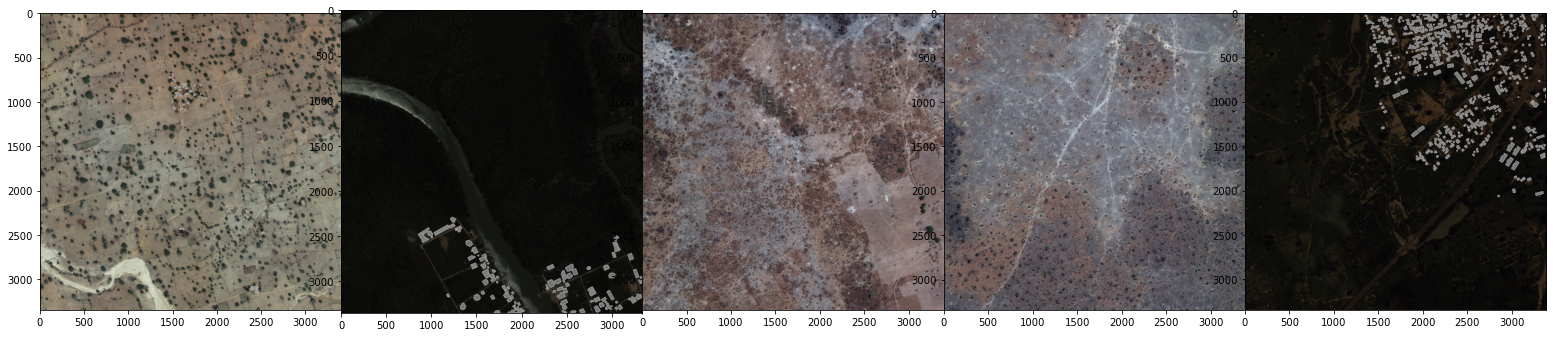

In [112]:
fig, axes = plt.subplots(1,5,figsize=(27,7))

plt.subplots_adjust(wspace=0, hspace=0)

for i,file in enumerate(test_imgs):
    with rasterio.open(os.path.join('three_band',file+".tif")) as raster:
        
        geom = gdf.loc[(gdf['ImageId']==file)& (gdf['ClassType']==1),'geometry'].values[0]
        if geom != None:
            axes[i].add_patch(PolygonPatch(geom,alpha=0.65,ec='#aaaaaa',fc='#aaaaaa'))
        rasterio.plot.show(utils.scale_pixels(raster),ax=axes[i])

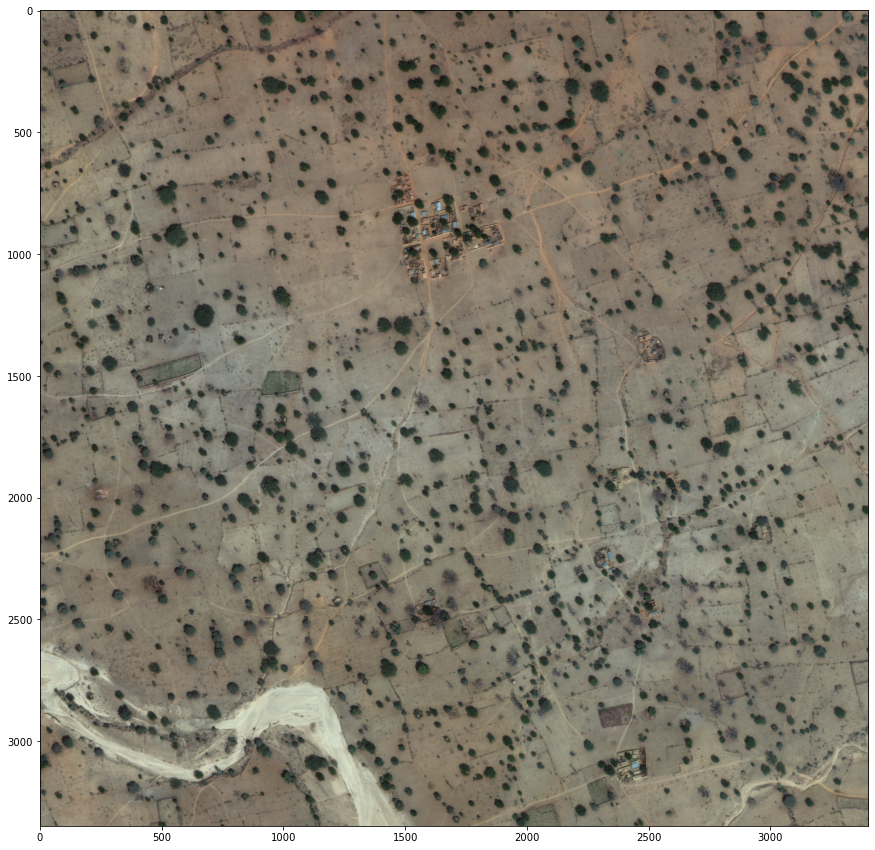

In [191]:
fig, axes = plt.subplots(1,figsize=(15,15))
with rasterio.open(os.path.join('three_band','6060_2_3'+".tif")) as raster:
    rasterio.plot.show(utils.scale_pixels(raster))

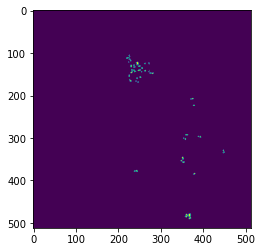

In [214]:
train_x_inspection = np.load(os.path.join('train','train_X','6060_2_3.npy'))

In [215]:
train_x_inspection = np.moveaxis(train_x_inspection,0,2)

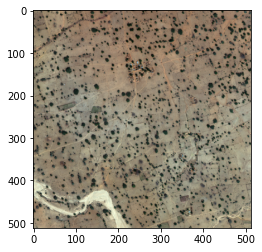

In [217]:
plt.imshow(train_x_inspection[:,:,[5,3,2]])

In [162]:
y_pred = model.predict(next(test_1_generator)[0])


In [166]:
for band in y_pred:
    print(f'Max: {np.max(band.squeeze())}\tMin: {np.min(band.squeeze())}')

Max: 0.1399354338645935	Min: 2.519152886293341e-09
Max: 0.06644779443740845	Min: 1.0036738107288556e-09
Max: 0.1399354338645935	Min: 2.519152886293341e-09
Max: 0.3941456377506256	Min: 0.0011430978775024414
Max: 0.1399354338645935	Min: 2.5191577712746493e-09


In [179]:
def display_img(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [200]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask#[0]

(512, 512, 1)
0.13993543
(512, 512, 1)
0


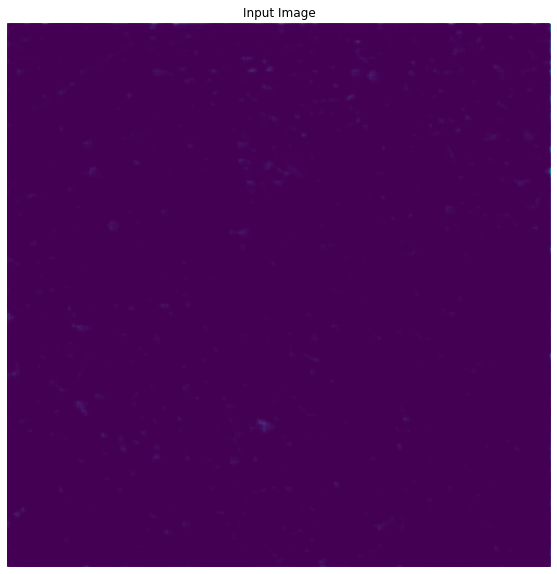

(512, 512, 1)
0.066447794
(512, 512, 1)
0


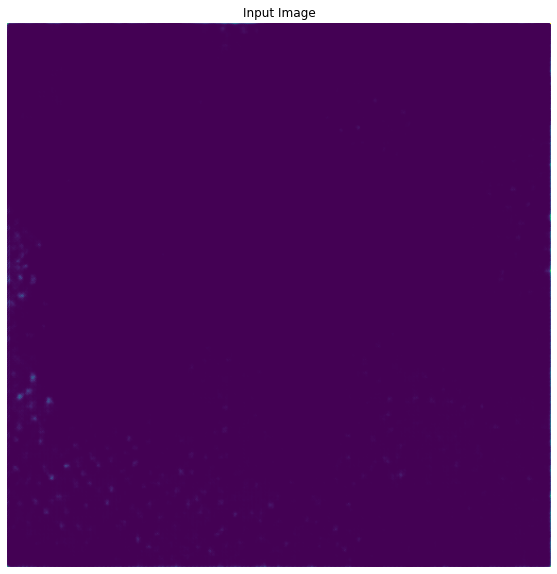

(512, 512, 1)
0.13993543
(512, 512, 1)
0


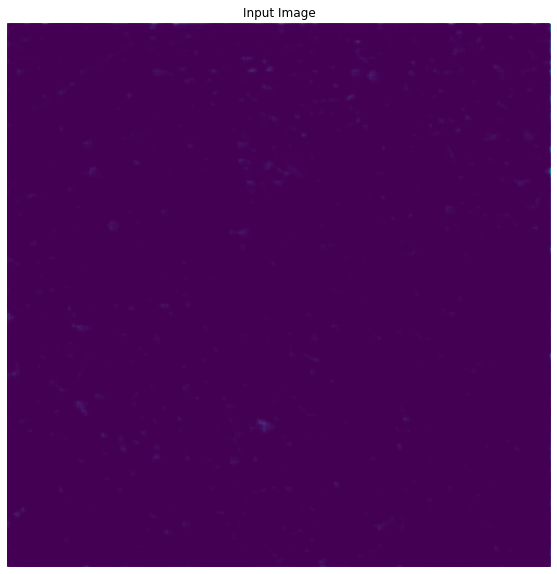

(512, 512, 1)
0.39414564
(512, 512, 1)
0


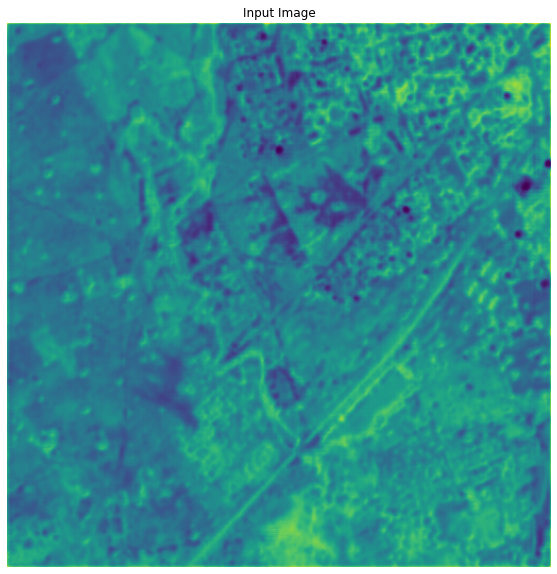

(512, 512, 1)
0.13993543
(512, 512, 1)
0


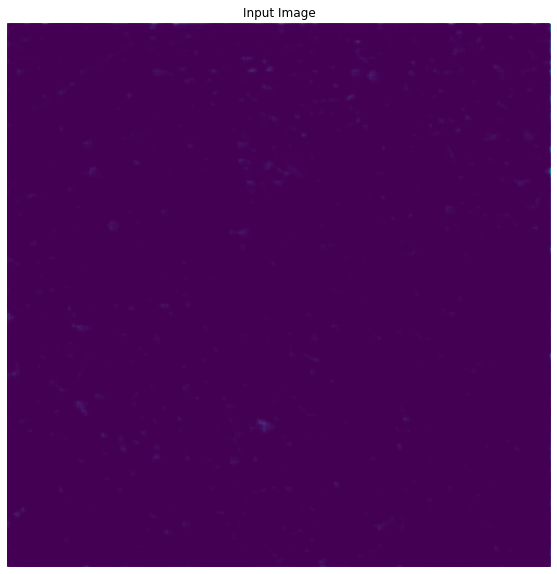

In [201]:
for pred_mask in y_pred:
    print(pred_mask.shape)
    print(np.max(pred_mask))
    mask = create_mask(pred_mask)
    print(mask.shape)
    print(np.max(mask))
    display_img([pred_mask])

In [167]:
test_mask = np.where(y_pred[4].squeeze() > 0.005,1,0)

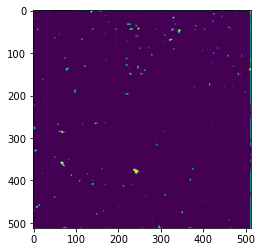

In [168]:
plt.imshow(test_mask)

In [97]:
gdf.head()

,ImageId,ClassType,area,geometry
0,6040_2_2,1,0.000000e+00,None
1,6040_2_2,2,0.000000e+00,None
2,6040_2_2,3,0.000000e+00,None
3,6040_2_2,4,1.088045e+05,"MULTIPOLYGON (((1119.759 2917.051, 1137.897 29..."
4,6040_2_2,5,2.127612e+06,"MULTIPOLYGON (((1965.963 3348.741, 1965.593 33..."


200    MULTIPOLYGON (((2430.794 3144.847, 2463.007 31...
Name: geometry, dtype: geometry